# Manipulation Examples

In this notebook, you can select a trained MLP (for Borda) to manipulate using majority matrix information. 

In [1]:
%run ./model_functions.ipynb # import all functions from model_functions.ipynb to this notebook

In [2]:
print("Available model sizes for Borda, 6 candidates and 10 voters trained using majority matrix information.")

for file in glob.glob(f"example_trained_models/Borda_1_6_10_uniform_('majority',)_1_08-18-2023_09-10-18.pickle"):
    agents = pickle.load(open(file, "rb"))
    for key in agents.keys():
        print(key[2])


Available model sizes for Borda, 6 candidates and 10 voters trained using majority matrix information.
(4,)
(8,)
(16,)
(32,)
(64,)
(128,)
(256,)
(512,)
(1024,)
(4, 4)
(8, 8)
(16, 8)
(16, 16)
(32, 32)
(64, 32)
(64, 64)
(128, 128)
(256, 128)
(256, 256)
(512, 512)
(1024, 1024)
(8, 8, 8)
(32, 16, 8)
(32, 32, 32)
(64, 64, 64)
(128, 64, 32)
(128, 128, 128)
(256, 256, 256)
(512, 256, 128)
(512, 512, 512)


Loading: example_trained_models/Borda_1_6_10_uniform_('majority',)_1_08-18-2023_09-10-18.pickle


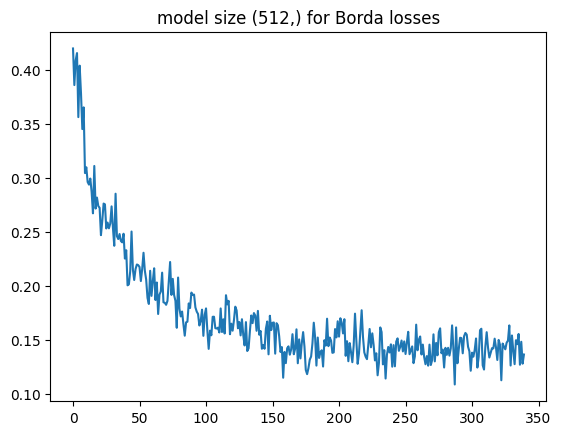

In [3]:

model_size = (512,)

# do not change the following parameters - due to the 50 MB limit, 
# only one family of models is included.
num_cands = 6
num_voters = 10
agent_infos = ('majority',)
vm = pref_voting.voting_methods.borda

probmodel = 'uniform'
labeling = 'satisfice'
generation = 1
manip_weight = 1

agent = get_agent(model_size, num_cands, num_voters, agent_infos, vm, probmodel=probmodel, labeling=labeling, gen=generation, manip_weight=manip_weight)


In [4]:

num_profiles = 1000

# generate utility profiles
utility_profiles = generate_utility_profile(
    num_cands, 
    num_voters, 
    probmodel = probmodel, 
    num_profiles = num_profiles
)

# get the utility functions for voter 0 and the linear profiles associated with each utility profile
elections = (
    [uprof.utilities[0] for uprof in utility_profiles],
    [to_linear_prof(uprof) for uprof in utility_profiles],
)

# get the submitted ranking for each utility profile and the profitability of that submitted ranking.
evals, actions = get_profits_actions(
    agent, 
    len(elections), 
    vm, 
    num_cands, 
    num_voters, 
    manip_weight, 
    elections, 
    decision_rule='argmax', 
    metric_op="normalized_subtract", 
    agent_infos=agent_infos)

evals = evals.detach().cpu().numpy()
actions = actions.detach().cpu().numpy()

# display all profitable manipulations and record data about the actions of the manipulator
num_manipulations = 0
num_sincere_votes = 0
num_profitable_manipulations = 0
num_unprofitable_manipulations = 0

for u, prof, profit, act in zip(elections[0], elections[1], evals, actions):
    sincere_ranking = prof.rankings[0]
    submitted_ranking = permutations_of[num_cands][act]
    if sincere_ranking != submitted_ranking: 
        num_manipulations += 1
        new_prof = apply_manipulation(prof, submitted_ranking, manip_weight=1)
        if profit > 0: 
            num_profitable_manipulations += 1
            print("Sincere profile")
            prof.display()
            vm.display(prof)
            print("Sincere ranking: ", sincere_ranking)
            print("Submitted ranking: ", submitted_ranking)
            print("After the manipulation: ")
            vm.display(new_prof)
            print("Profitability: ", profit)
            print()

        elif profit < 0: 
            num_unprofitable_manipulations += 1
    else: 
        num_sincere_votes += 1

print()
print("Results")
print("Percent of profiles that voter 0 submits a sincere ranking:\n ", round(num_sincere_votes / num_profiles, 3))
print("Percent of profiles that voter 0 does not submit a sincere ranking:\n ", round(num_manipulations / num_profiles, 3))
print("Of the manipulations, the percent that do not change the winning set:\n", round((num_manipulations - (num_profitable_manipulations + num_unprofitable_manipulations)) / num_manipulations, 3))

print("Of the manipulations that change the outcome, the percent that are profitable:\n", round(num_profitable_manipulations / (num_profitable_manipulations + num_unprofitable_manipulations), 3))
print("Of the manipulations that change the outcome, the percent that are unprofitable:\n", round(num_unprofitable_manipulations / (num_profitable_manipulations + num_unprofitable_manipulations), 3))


Sincere profile
+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+
| 4 | 0 | 1 | 3 | 2 | 0 | 5 | 3 | 0 | 2 |
| 2 | 2 | 2 | 4 | 0 | 3 | 1 | 4 | 4 | 0 |
| 5 | 3 | 0 | 2 | 1 | 1 | 4 | 5 | 1 | 1 |
| 3 | 5 | 5 | 1 | 3 | 5 | 2 | 0 | 2 | 3 |
| 0 | 1 | 4 | 5 | 5 | 4 | 0 | 2 | 3 | 5 |
| 1 | 4 | 3 | 0 | 4 | 2 | 3 | 1 | 5 | 4 |
+---+---+---+---+---+---+---+---+---+---+
Borda winners are {0, 2}
Sincere ranking:  (4, 2, 5, 3, 0, 1)
Submitted ranking:  (2, 4, 5, 3, 1, 0)
After the manipulation: 
Borda winner is {2}
Profitability:  0.29891872

Sincere profile
+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+
| 2 | 4 | 2 | 3 | 4 | 4 | 0 | 5 | 3 | 4 |
| 0 | 2 | 3 | 5 | 1 | 3 | 1 | 2 | 1 | 2 |
| 4 | 3 | 5 | 4 | 2 | 0 | 4 | 1 | 4 | 1 |
| 5 | 5 | 1 | 2 | 5 | 2 | 2 | 4 | 0 | 3 |
| 1 | 0 | 0 | 0 | 0 | 5 | 5 | 0 | 2 | 5 |
| 3 | 1 | 4 | 1 | 3 | 1 | 3 | 3 | 5 | 